In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import random

# PD 4 - Analiza wrażliwości modelu
Celem zadania jest przeanalizowanie wrażliwości sieci neuronowej na zaburzenia danyc wejściowych i wartości wag. Analiza wrażliwości jest ważnym elementem badania jakości modelu, zwłaszcza badanie odporności na zaburzenia danych wejściowych. Ma to duże znaczenie w szczególności w sytuacjach gdzie od modelu zależy bezpieczeństwo np. system prowadzenia autonomicznego prowadzenia samochodu. 

Analizę przeprowadzimy na przykładzie prostej sieci konwolucyjnej klasyfikującej zbiór danych MNIST.

## Model wyjściowy

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [99]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(3),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
print(model.summary())
history = model.fit(x_train, y_train, epochs=10, validation_split=0.15)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                32784     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 33,274
Trainable params: 33,274
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1594/1594 [==============================] - 9s 6ms/step - loss: 0.6184 - accuracy: 0.8049 - val_los

In [10]:
#model.save_weights('base_weights.h5')

## Zaburzanie danych wejściowych
Na początku zbadajmy wpływ zaburzenia danych wejściowych na działanie sieci. Zaburzenie będzie polegało na nastawieniu wartości `0.75` losowym pikselom każdego obrazka. Ile takich pikseli ma być zaburzonych ustawimy parametrem na `image_fraction` na wartość `0.05`, czyli 5% pikseli zostanie zmienionych.

In [4]:
# funkcja zaburzająca dane w calym podanym zbiorze
def perturbate_data(X_source, data_fraction, image_fraction):
    X = X_source.copy()
    x_length = X.shape[0]
    
    for i_sample in np.random.choice(x_length, int(data_fraction*x_length)):
        image = X[i_sample].copy()
        image = np.reshape(image, (-1))
        pixel_indexes = np.random.choice(784, int(784*image_fraction), replace=False)
        image[pixel_indexes] = 0.75
        image = np.reshape(image, (28,28,1))
        X[i_sample] = image
    
    return X

In [52]:
x_changed = perturbate_data(x_test, 1, 0.05)

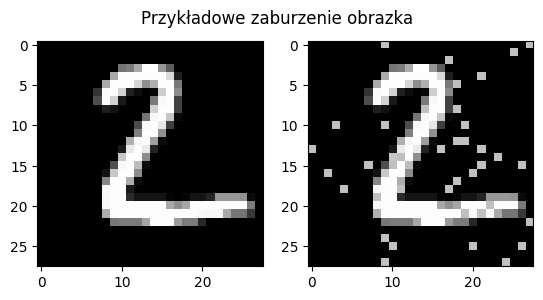

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(x_test[1][:,:,0], cmap='gray') 
ax2.imshow(x_changed[1][:,:,0], cmap='gray')
#fig.set_size_inches(10,5)
fig.suptitle('Przykładowe zaburzenie obrazka')
fig.subplots_adjust(top=1.25)
plt.show()

Model na oryginalnych danych testowych uzyskał dokładność 98.6%. Podczas 20 prób na zaburzoncych danych testowych, dokładność spadała średnio do  82.5%. Co ciekawe, odchylenie standardowe jest bardzo małe (0.00229), wszystkie próby dały prawie identyczne wyniki.

In [44]:
# wynik na zbiorze testowym, bedzie to nasz punkt odniesienia
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model.predict(x_test), axis=-1)
print(accuracy_score(y_test, y_pred))

0.9861


In [46]:
results = []
for i in range(20):
    x_changed = perturbate_data(x_test, 1, 0.05)
    y_pred = np.argmax(model.predict(x_changed), axis=-1)
    results.append(accuracy_score(y_test, y_pred))
results = pd.Series(results)
print('Mean accuracy: ', results.mean())
print('std: ', results.std())

Mean accuracy:  0.825005
std:  0.002288753970360746


Ponieważ wyniki na zaburzonych danych mają małe odchylenie standardowe, można małym kosztem (bez konieczności wielokrotnego powtarzania) sprawdzić jak liczba zmienionych pikseli (sprawdzimy dla zakresu od 0% do 80% zmienionych pikseli) będzie wpływać na wyniki predykcji.

In [92]:
results = []
for image_fraction in np.linspace(0,0.8, num = 80):
    for _ in range(3):
        x_changed = perturbate_data(x_test, 1, image_fraction)
        y_pred = np.argmax(model.predict(x_changed), axis=-1)
        results.append({'changed_pixel_rate':image_fraction, 'accuracy':accuracy_score(y_test, y_pred)})
results = pd.DataFrame(results)

[(0.0, 1.0)]

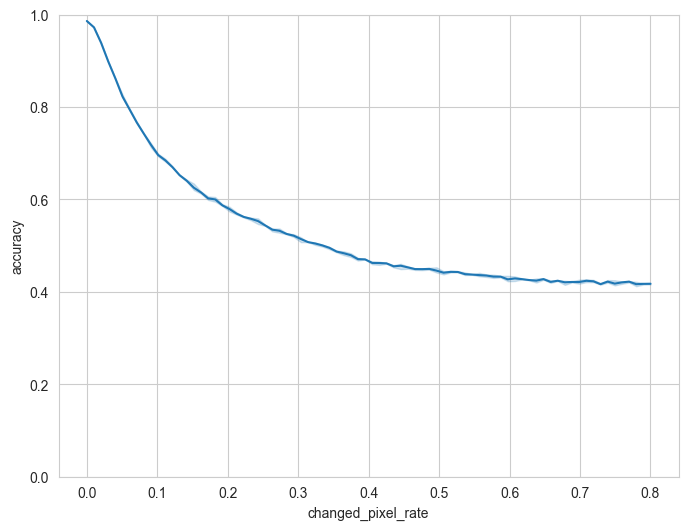

In [98]:
sns.set_style("whitegrid")
g = sns.lineplot(data=results, x='changed_pixel_rate', y='accuracy')
g.figure.set_size_inches(8,6)
g.set(ylim=(0,1))

Największe spadki dokładnośći następują przy zwiększaniu liczby zmienionych pikseli do 20%. Dalsze zmienianie wartości pikseli nie ma aż takiego wpływu, zbiegając do wartości około 42%. Można również zauważyć, że małe odchylenie standardowe występuje również dla wszystkich innych odsetków zmienionych pikseli (dla każdej liczby zmienionych pikseli test przeprowadzono trzy razy, a wykres posiada zakresy niepewności).

## Zaburzanie wag modelu
Teraz sprawdźmy jak zaburzenie wag modelu wpłynie na jego wyniki klasyfikacji. Zaburzenie będzie polegało na przemnożeniu wag przez losowy mnożnik z zakresu `[1/a, a]` gdzie `a` podajemy jako parametr funkcji dokonującej zaburzenia (`factor_range`).

In [79]:
# funkcja zmieniajaca losowe elementy wielowymiarowej macierzy
def perturbate_matrix(X_input, fraction, factor_range=2):
    X = X_input.copy()
    shape = X.shape
    X = np.reshape(X, (-1))
    indexes = np.random.choice(len(X), int(len(X)*fraction), replace=False)
    X[indexes] *= random.uniform(1/factor_range, factor_range)
    X = np.reshape(X, shape)
    return X

# funkcja zmieniajaca losowo wagi podanej warstwy modelu
def perturbate_layer(model, layer_i, factor_range):
    if len(model.layers[layer_i].get_weights()) != 0:
            weights = model.layers[layer_i].get_weights()
            weights[0] = perturbate_matrix(weights[0], 1, factor_range)
            weights[1] = perturbate_matrix(weights[1], 1, factor_range)
            model.layers[layer_i].set_weights(weights)
            
# funkcja zmieniajaca losowo wszystkie wagi modelu
def perturbate_all_weights(model,factor_range):
    for layer_i in range(len(model.layers)):
        perturbate_layer(model, layer_i, factor_range)
            

### Zaburzenie wszystkich wag
Rozregulujmy teraz wagi wszystkich warstw i sprawdźmy dokładność modelu na zbiorze testowym. Każdą wagę przemnożymy przez losowy mnożnik z zakresu `[0.333, 3]`. Powtórzmy to 20 razy aby zmierzyć odchylenie standardowe.

In [80]:
results = []
for i in range(20):
    model.load_weights('base_weights.h5')
    perturbate_all_weights(model, 3)
    y_pred = np.argmax(model.predict(x_test), axis=-1)
    results.append(accuracy_score(y_test, y_pred))
results = pd.Series(results)
print('Mean accuracy: ', results.mean())
print('std: ', results.std())

Mean accuracy:  0.7184250000000001
std:  0.26509602803314003


Podczas prób, dokładność spadła średnio do 71.8% (z pierwotnych 98.6%). Odchylenie standardowe w tym przypadku jest już znacznie większe (0.265) niż w przypadku perturbacji danych wejściowych.

### Zaburzanie wag warstwy gęstej
Zróbmy to samo ale tylko w przypadku przedostatniej warstwy gęstej. Jako że będziemy zmieniać wagi tylko jednej warstwy, zwiększmy zakres możliwych mnożników do `[0.2, 5]`.

In [83]:
model.layers

In [82]:
results = []
for i in range(20):
    model.load_weights('base_weights.h5')
    perturbate_layer(model, 3, 5)
    y_pred = np.argmax(model.predict(x_test), axis=-1)
    results.append(accuracy_score(y_test, y_pred))
results = pd.Series(results)
print('Mean accuracy: ', results.mean())
print('std: ', results.std())

Mean accuracy:  0.9837200000000001
std:  0.009530262049746689


Zaburzenia wag warstwy gęstej najmniej wpłynęły na wyniki osiągane przez model. Dokładność spadała średnio do 98.3% co jest wynikiem gorszym tylko o 0.03% od pierwotnej niezaburzonej sieci. Małe odchylenie standardowe (0.009) wskazuje że jest to całkiem powatrzalny rezultat.

### Źródła
* [Hai Shu, Hongtu Zhu, Sensitivity Analysis of Deep Neural Networks](https://arxiv.org/abs/1901.07152)